In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ardi_data = pd.read_csv("Cleaned_1_data.csv")

ardi_data

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,ConditionType,Category,Cause_of_Death,Data_Value_Alt,Effect,ConsumptionPattern,Sex,AgeGroup
0,2015,2019,AL,Alabama,ARDI,Acute,Alcohol-Related Poisonings,Poisoning (not alcohol),10.0,Harmful Effects,Excessive Alcohol Use,Overall,65+
1,2015,2019,AL,Alabama,ARDI,Acute,Alcohol-Related Poisonings,Poisoning (not alcohol),54.0,Harmful Effects,Excessive Alcohol Use,Overall,50-64
2,2015,2019,AL,Alabama,ARDI,Acute,Alcohol-Related Poisonings,Poisoning (not alcohol),82.0,Harmful Effects,Excessive Alcohol Use,Overall,35-49
3,2015,2019,AL,Alabama,ARDI,Acute,Motor Vehicle Traffic Crashes,Motor vehicle traffic crashes,115.0,Harmful Effects,Excessive Alcohol Use,Overall,20-34
4,2015,2019,AL,Alabama,ARDI,Acute,Motor Vehicle Traffic Crashes,Motor vehicle traffic crashes,23.0,Harmful Effects,Excessive Alcohol Use,Overall,0-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122,2015,2019,WY,Wyoming,ARDI,Chronic,100% Alcohol-Attributable,Alcohol abuse,12.0,Harmful Effects,Any Alcohol Use,Overall,50-64
4123,2015,2019,WY,Wyoming,ARDI,Chronic,100% Alcohol-Attributable,Alcoholic liver disease,14.0,Harmful Effects,Any Alcohol Use,Overall,65+
4124,2015,2019,WY,Wyoming,ARDI,Chronic,100% Alcohol-Attributable,Alcoholic liver disease,24.0,Harmful Effects,Any Alcohol Use,Overall,35-49
4125,2015,2019,WY,Wyoming,ARDI,Chronic,100% Alcohol-Attributable,Alcoholic liver disease,43.0,Harmful Effects,Any Alcohol Use,Overall,50-64


In [4]:
unique_cat = ardi_data['ConsumptionPattern'].unique()
print(unique_cat)

['Excessive Alcohol Use' 'Any Alcohol Use']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the data
ardi_data = pd.read_csv("Cleaned_1_data.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = ['LocationDesc', 'ConditionType', 'AgeGroup', 'Category', 'Cause_of_Death']
for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on condition using SVR
def predict_by_consumption(consumption):
    df_filtered = ardi_data[ardi_data['ConsumptionPattern'] == consumption]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['LocationDesc', 'ConditionType', 'AgeGroup', 'Category', 'Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = SVR(kernel='linear')  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    svr_mse = mean_squared_error(y_test, y_pred)
    svr_mae = mean_absolute_error(y_test, y_pred)
    svr_r2 = r2_score(y_test, y_pred)
    
    return y_pred, svr_mse, svr_mae, svr_r2

# Define the list of models
models = ['Gradient Boosting', 'XGBoost', 'SVR', 'RandomForest']

# Initialize lists to store metrics for each model
mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over each model
for model_name in models:
    # Call the corresponding prediction function based on the model
    if model_name == 'Gradient Boosting':
        model = GradientBoostingRegressor()
    elif model_name == 'XGBoost':
        model = XGBRegressor()
    elif model_name == 'SVR':
        prediction_func = predict_by_condition_svr
    elif model_name == 'RandomForest':
        model = RandomForestRegressor()

    if model_name != 'SVR':
        X = ardi_data[['LocationDesc', 'ConditionType', 'AgeGroup', 'Category', 'Cause_of_Death']]
        y = ardi_data['Data_Value_Alt']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

    else:
        consumption = 'Excessive Alcohol Use'
        prediction, mse, mae, r2 = predict_by_consumption(consumption)

    # Append the metrics to the respective lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    # Print the results
    print(f"{model_name} Predicted values for '{consumption}':", prediction)
    print(f"{model_name} Mean Squared Error (MSE):", mse)
    print(f"{model_name} Mean Absolute Error (MAE):", mae)
    print(f"{model_name} R-squared (R2):", r2)
    print()

# Plot Mean Squared Error (MSE)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, mse_scores, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) among Models using Condition')

# Add annotations to the bars
for bar, mse in zip(bars, mse_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mse:.2f}', ha='center', va='bottom')

plt.show()

# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, mae_scores, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error (MAE) among Models using Condition')

# Add annotations to the bars
for bar, mae in zip(bars, mae_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mae:.2f}', ha='center', va='bottom')

plt.show()

# Plot R-squared (R2)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, r2_scores, color='orange')
plt.xlabel('Models')
plt.ylabel('R-squared (R2)')
plt.title('Comparison of R-squared (R2) among Models using Condition')

# Add annotations to the bars
for bar, r2 in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{r2:.2f}', ha='center', va='bottom')

plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder


def predict_with_models(ardi_data):
    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']  
    for col in categorical_columns:
        le = LabelEncoder()
        ardi_data[col] = le.fit_transform(ardi_data[col])
        label_encoders[col] = le

    # Function to make predictions based on condition using Gradient Boosting
    def predict_by_condition_gb(X_train, X_test, y_train, y_test):
        model = GradientBoostingRegressor()  
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return y_pred, mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

    # Function to make predictions based on condition using XGBoost
    def predict_by_condition_xgb(X_train, X_test, y_train, y_test):
        model = XGBRegressor()  
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return y_pred, mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

    # Function to make predictions based on condition using RandomForest
    def predict_by_condition_rf(X_train, X_test, y_train, y_test):
        model = RandomForestRegressor()  
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return y_pred, mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

    # Function to make predictions based on condition using SVR
    def predict_by_condition_svr(X_train, X_test, y_train, y_test):
        model = SVR(kernel='linear')  
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return y_pred, mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

    # List of models and their corresponding functions
    models = {
        'Gradient Boosting': predict_by_condition_gb,
        'XGBoost': predict_by_condition_xgb,
        'RandomForest': predict_by_condition_rf,
        'SVR': predict_by_condition_svr
    }

    # Example consumption pattern
    consumption = 'Excessive Alcohol Use'

    # Features and target
    X = ardi_data[['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']]
    y = ardi_data['Data_Value_Alt']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Iterate over each model, make predictions, and evaluate performance
    results = {}
    for model_name, predict_function in models.items():
        y_pred, mse, mae, r2 = predict_function(X_train, X_test, y_train, y_test)
        results[model_name] = {'Predictions': y_pred, 'MSE': mse, 'MAE': mae, 'R2': r2}

    return results

# Example usage
ardi_data = pd.read_csv("Cleaned_1_data.csv")
results = predict_with_models(ardi_data)
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print("Mean Squared Error (MSE):", metrics['MSE'])
    print("Mean Absolute Error (MAE):", metrics['MAE'])
    print("R-squared (R2):", metrics['R2'])
    print()


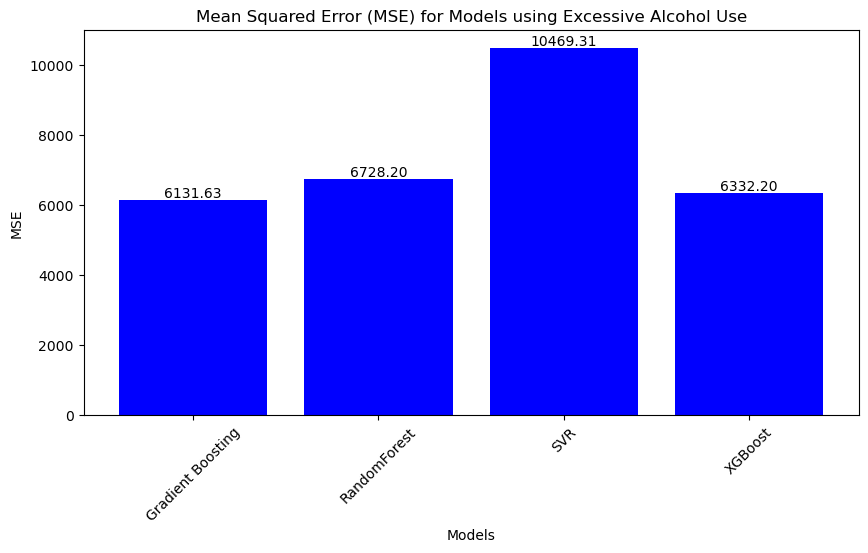

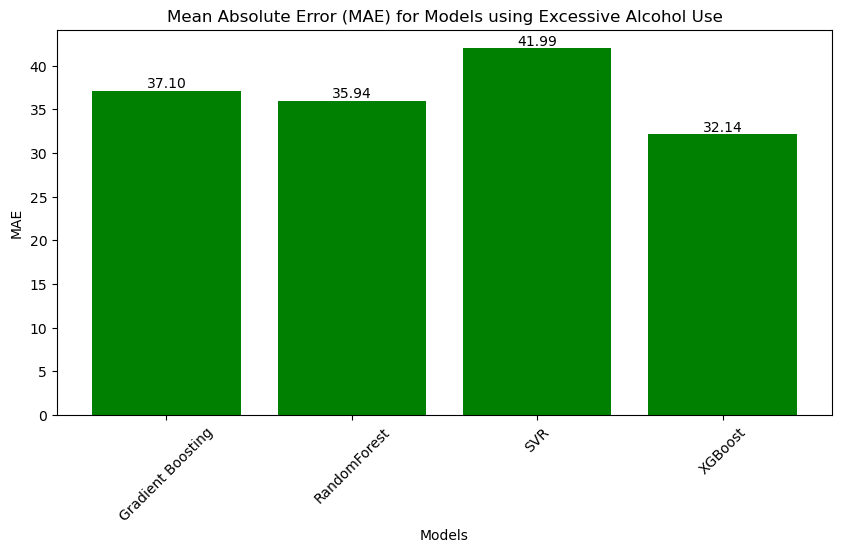

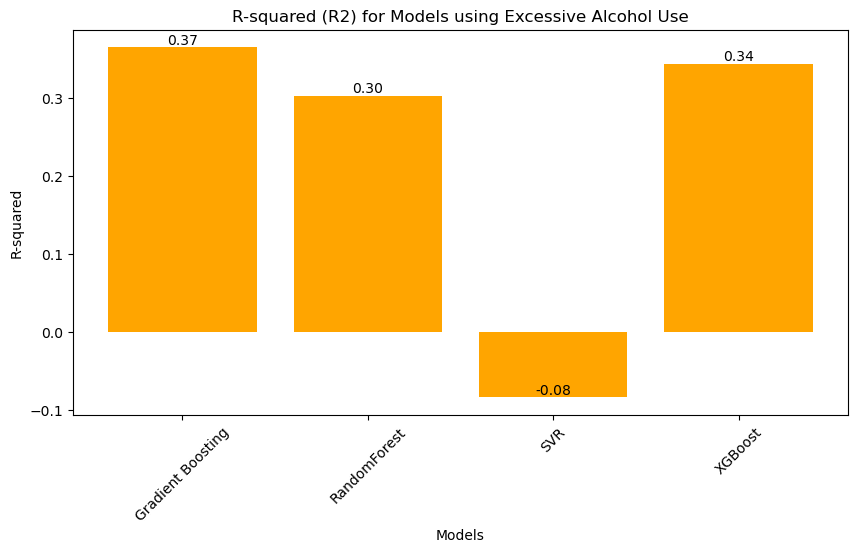

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def predict_with_models(ardi_data, consumption_value):
    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['LocationDesc', 'ConditionType', 'AgeGroup', 'Category', 'Cause_of_Death']
    
    for col in categorical_columns:
        le = LabelEncoder()
        ardi_data[col] = le.fit_transform(ardi_data[col])
        label_encoders[col] = le

    # Filter data by consumption value
    filtered_data = ardi_data[ardi_data['ConsumptionPattern'] == consumption_value]
    
    # Check if there are enough samples for training and testing
    if len(filtered_data) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    # Split data into features and target
    X = filtered_data[['LocationDesc', 'ConditionType', 'AgeGroup', 'Category', 'Cause_of_Death']]
    y = filtered_data['Data_Value_Alt']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'Gradient Boosting': GradientBoostingRegressor(),
        'RandomForest': RandomForestRegressor(),
        'SVR': SVR(kernel='linear'),
        'XGBoost': XGBRegressor()
    }

    # Make predictions and evaluate each model
    mse_results = {}
    mae_results = {}
    r2_results = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_results[model_name] = mse
        mae_results[model_name] = mae
        r2_results[model_name] = r2

    # Plot MSE for all models
    plt.figure(figsize=(10, 5))
    bars = plt.bar(mse_results.keys(), mse_results.values(), color='blue')
    plt.title(f'Mean Squared Error (MSE) for Models using {consumption_value}')
    plt.xlabel('Models')
    plt.ylabel('MSE')
    plt.xticks(rotation=45)
    
    # Add annotations to the bars
    for bar, mse in zip(bars, mse_results.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mse:.2f}', ha='center', va='bottom')

    plt.show()

    # Plot MAE for all models
    plt.figure(figsize=(10, 5))
    bars = plt.bar(mae_results.keys(), mae_results.values(), color='green')
    plt.title(f'Mean Absolute Error (MAE) for Models using {consumption_value}')
    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.xticks(rotation=45)
    
    # Add annotations to the bars
    for bar, mae in zip(bars, mae_results.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mae:.2f}', ha='center', va='bottom')

    plt.show()

    # Plot R-squared for all models
    plt.figure(figsize=(10, 5))
    bars = plt.bar(r2_results.keys(), r2_results.values(), color='orange')
    plt.title(f'R-squared (R2) for Models using {consumption_value}')
    plt.xlabel('Models')
    plt.ylabel('R-squared')
    plt.xticks(rotation=45)
    
    # Add annotations to the bars
    for bar, r2 in zip(bars, r2_results.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{r2:.2f}', ha='center', va='bottom')

    plt.show()

# Load your ARDI data
ardi_data = pd.read_csv("Cleaned_1_data.csv")

# Specify the consumption value for filtering
consumption_value = 'Excessive Alcohol Use'

# Perform prediction with models for the specified consumption value
predict_with_models(ardi_data, consumption_value)


In [7]:
#  1

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder


# Encode categorical variables
label_encoders = {}
categorical_columns = ['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']  # List of categorical columns to encode

for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on condition using SVR
def predict_by_condition_svr(condition):
    df_filtered = ardi_data[ardi_data['ConsumptionPattern'] == consumption]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    model = SVR(kernel='linear')  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    svr_mse = mean_squared_error(y_test, y_pred)
    svr_mae = mean_absolute_error(y_test, y_pred)
    svr_r2 = r2_score(y_test, y_pred)
    
    return y_pred, svr_mse, svr_mae, svr_r2

# Example prediction using SVR based on AgeGroup
consumption  = 'Excessive Alcohol Use'

prediction, svr_mse, svr_mae, svr_r2 = predict_by_condition_svr(consumption)
print(f"SVR Predicted values for '{consumption}':", prediction)
print("Mean Squared Error (MSE):", svr_mse)
print("Mean Absolute Error (MAE):", svr_mae)
print("R-squared (R2):", svr_r2)


SVR Predicted values for 'Excessive Alcohol Use': [28.1924699  31.16283134 31.65996093 26.79763259 28.36563281 34.11175566
 38.030096   33.14655286 25.10598863 30.52345364 30.05348408 32.68107627
 32.45878653 37.37774148 26.36964855 27.93386988 28.10234163 35.01585269
 23.8043582  27.08359084 30.88183426 26.48430231 25.41083506 38.20562345
 27.17325091 44.81976513 36.15184411 24.76956101 26.68908434 36.73693563
 29.74677924 30.50882635 43.97981861 44.53096438 25.22300694 31.17745863
 25.91620263 29.39994729 44.05295505 24.10329327 45.51908013 36.97972609
 37.50938707 31.99638856 36.22498055 28.48075477 45.32892538 30.11388958
 26.24179564 33.54129143 31.87677363 43.27206743 33.96548278 38.11785972
 36.13721683 38.19099616 29.70901668 30.58006645 28.33874278 37.14370487
 29.51696559 30.89907196 24.52326166 31.36714517 29.79488406 26.96657253
 24.21841523 32.8540071  45.02829217 23.97988566 25.70291261 35.42327454
 32.84197643 25.79067634 43.54099997 30.65347289 26.90806338 30.09736595
 

In [10]:
# Age based 2

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# # Load the dataset from ardi_data
# df = pd.read_csv('ardi_data.csv')

# Encode categorical variables
label_encoders = {}
categorical_columns = ['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']  # List of categorical columns to encode

for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on condition using Gradient Boosting
def predict_by_consumption_gb(condition):
    df_filtered = ardi_data[ardi_data['ConsumptionPattern'] == consumption]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    model = GradientBoostingRegressor()  # Using Gradient Boosting for regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    gb_mse = mean_squared_error(y_test, y_pred)
    gb_mae = mean_absolute_error(y_test, y_pred)
    gb_r2 = r2_score(y_test, y_pred)
    
    return y_pred, gb_mse, gb_mae, gb_r2

# Example prediction using Gradient Boosting based on condition
consumption  = 'Excessive Alcohol Use'

prediction, gb_mse, gb_mae, gb_r2 = predict_by_consumption_gb(consumption)
print(f"Gradient Boosting Predicted values for '{consumption}':", prediction)
print("Mean Squared Error (MSE):", gb_mse)
print("Mean Absolute Error (MAE):", gb_mae)
print("R-squared (R2):", gb_r2)


Gradient Boosting Predicted values for 'Excessive Alcohol Use': [ 40.07492567  58.61864417 108.83416478  20.37346697 111.10634377
  65.53815573  93.45138549  38.55866491  54.06521878  30.41199756
  35.90760009  55.61376699  51.63737973  93.45138549  84.53935945
  19.31840128 213.67769479  52.09160276  28.98064535  54.62207163
  75.70491306  75.96074444  16.14036551 117.48616055  87.95229129
  94.81298336  55.35432183  40.15926151 105.22633473  67.73995814
  79.87355775  30.41199756  80.42377839  50.69699943  24.88900929
 144.06572539  98.26573954  20.86537581  55.57826699  24.50044522
  82.44171569  63.12998981  96.29763695  93.89797852  59.01374442
  35.04219298  72.99822044  14.26350742  18.69138514  48.66860308
  47.5127433  129.38758305  83.61530416  83.94241948  58.44376096
 117.48616055  60.39419939  25.14294294  66.58106358  84.00789024
  23.71162727  23.6346733   69.05316642  68.64154421  25.14294294
  32.60318537  75.29355484  27.54543858  40.98642996  19.31840128
  85.3081513

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
categorical_columns = ['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']  # List of categorical columns to encode

for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on condition using XGBoost
def predict_by_condition_xgb(condition):
    df_filtered = ardi_data[ardi_data['ConditionType'] == condition]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['LocationDesc','ConditionType', 'AgeGroup', 'Category','Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    model = XGBRegressor()  # Using XGBoost for regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    xgboost_mse = mean_squared_error(y_test, y_pred)
    xgboost_mae = mean_absolute_error(y_test, y_pred)
    xgboost_r2 = r2_score(y_test, y_pred)
    
    return y_pred, xgboost_mse, xgboost_mae, xgboost_r2

# Example prediction using XGBoost based on condition
condition = 'Acute'

prediction, xgboost_mse, xgboost_mae, xgboost_r2 = predict_by_condition_xgb(condition)
print(f"XGBoost Predicted values for '{condition}':", prediction)
print("Mean Squared Error (MSE):", xgboost_mse)
print("Mean Absolute Error (MAE):", xgboost_mae)
print("R-squared (R2):", xgboost_r2)


XGBoost Predicted values for 'Acute': [  60.349133    95.01124     39.167747   372.30023     36.69465
  355.9484      73.27223    243.60391      5.442816    16.65614
  179.53764    396.68604     58.710667     9.825547    48.830948
   92.726036    22.294748    25.694344    12.285109    48.024254
   29.746664   417.93753     60.323414    79.45789     90.90829
   73.626236   959.4131     176.47658     31.962883    18.051815
   24.463432    73.99828     45.943153    25.372997   191.45226
   96.83458      7.213083    50.48994     13.655746   130.2777
    3.278979    64.07491    222.34071     30.55579     36.412273
  444.89426     65.003654   200.47646     23.878014   190.67104
   34.651474     5.442816    86.080894    91.53419     25.606266
    8.779205    29.301153   139.19984     73.626236    28.501083
   11.478185   152.53976     11.860717   253.76685     34.603447
   64.42658     40.803562   159.07565     21.733482    23.995148
  101.02915     80.905205    46.042686    45.739437   195.2

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
categorical_columns = ['LocationAbbr', 'Sex', 'AgeGroup', 'Category', 'Cause_of_Death']  # List of categorical columns to encode

for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on condition using Random Forest
def predict_by_condition_rf(condition):
    df_filtered = ardi_data[ardi_data['ConditionType'] == condition]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['LocationAbbr', 'Sex', 'AgeGroup', 'Category', 'Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor()  # Using RandomForestRegressor for regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    rf_mse = mean_squared_error(y_test, y_pred)
    rf_mae = mean_absolute_error(y_test, y_pred)
    rf_r2 = r2_score(y_test, y_pred)
    
    return y_pred, rf_mse, rf_mae, rf_r2

# Example prediction using Random Forest based on condition
condition = 'Acute'

prediction, rf_mse, rf_mae, rf_r2 = predict_by_condition_rf(condition)
print(f"Random Forest Predicted values for '{condition}':", prediction)
print("Mean Squared Error (MSE):", rf_mse)
print("Mean Absolute Error (MAE):", rf_mae)
print("R-squared (R2):", rf_r2)


Random Forest Predicted values for 'Acute': [ 38.86 102.26  47.62 254.52  32.11 296.25  75.71 215.77  41.88  52.29
 185.62 310.92  54.28  15.24  49.57 147.26  19.8   30.23  18.52  50.4
  91.59 715.18  55.03  58.4   90.68 103.71 898.61 159.48  96.95  17.32
  27.76  68.53  68.2   34.49 183.34  83.94  92.56  57.91  46.05 156.64
  23.25 273.48 252.75  43.2   45.17 357.69  62.16 130.74  36.57 225.08
  31.02  41.88  47.77 129.7   67.66  21.59  33.12 168.92 103.71  44.78
  14.38 186.34  30.28 263.63  40.47  62.45  77.98 128.14  32.41  63.55
 101.68  97.74  39.27  78.09 202.55  46.02  29.92  81.21 130.74  55.13
  22.77  59.34  47.77 156.64  21.26  59.4  159.48  48.28 120.08  50.4
 147.74  44.5  189.79 281.04  23.99  25.84 653.69  49.93 120.34 112.07
  29.06  40.94 177.25  18.56  26.77  25.29  59.4  173.9   24.98 212.99
  14.33  31.07  82.37  40.77 113.6  120.39 108.93  35.5  189.79  14.91
 104.65 131.    26.74  16.32  48.4   59.26  14.12  65.3  714.43 117.79
 119.04 225.08  80.85  42.04  31.76

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables

label_encoders = {}
categorical_columns = ['LocationAbbr', 'Sex', 'AgeGroup', 'Category', 'Cause_of_Death']  # List of categorical columns to encode

for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on condition using Linear Regression
def predict_by_condition_linear(condition):
    df_filtered = ardi_data[ardi_data['ConditionType'] == condition]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['LocationAbbr', 'Sex', 'AgeGroup', 'Category', 'Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()  # Using Linear Regression for regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    linear_mse = mean_squared_error(y_test, y_pred)
    linear_mae = mean_absolute_error(y_test, y_pred)
    linear_r2 = r2_score(y_test, y_pred)
    
    return y_pred, linear_mse, linear_mae, linear_r2

# Example prediction using Linear Regression based on condition
condition = 'Acute'

prediction, linear_mse, linear_mae, linear_r2 = predict_by_condition_linear(condition)
print(f"Linear Regression Predicted values for '{condition}':", prediction)
print("Mean Squared Error (MSE):", linear_mse)
print("Mean Absolute Error (MAE):", linear_mae)
print("R-squared (R2):", linear_r2)


Linear Regression Predicted values for 'Acute': [ 33.23015993 140.74868038  69.1726218  254.88550835 129.95686072
 178.52794132 141.71891328 255.61318303   6.61242677  37.8387662
 251.73225143 150.03512837 126.56104557  27.16620431  63.24755768
 177.66137516  20.98299092  21.28517803 -26.94849071 182.16631469
 254.4003919  100.41399531  70.2817462   68.82639685  72.22221199
  75.47913565 260.46434752 176.69114226 250.27690208 -29.13151473
  74.0237863   76.69192677 143.24349808  32.9876017  180.71096535
 132.62500119  67.85616395 181.0571903  139.84768293 260.94946397
  36.14085862 104.88371009 145.8424031  137.59542346  35.41318395
 258.03876528  63.73267413 177.55770842  73.29611163 178.14649161
  66.64337282   6.61242677  89.30212584 254.15783368 261.43458042
  77.9047179   70.1428547  261.1920222   75.47913565  29.34922833
  28.07680832 148.7531018  144.69884743 259.00899818 127.28872025
  84.20840312 -14.38127189  28.62155366  38.56644087 255.12806658
 126.50141669 255.3706248   6

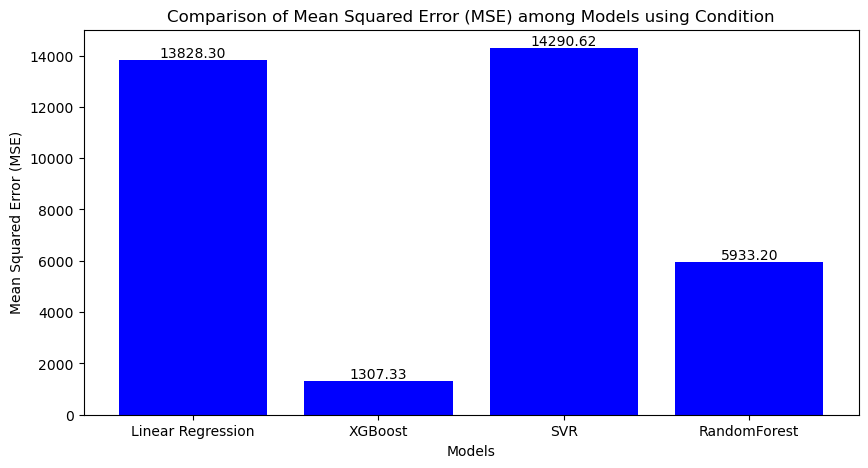

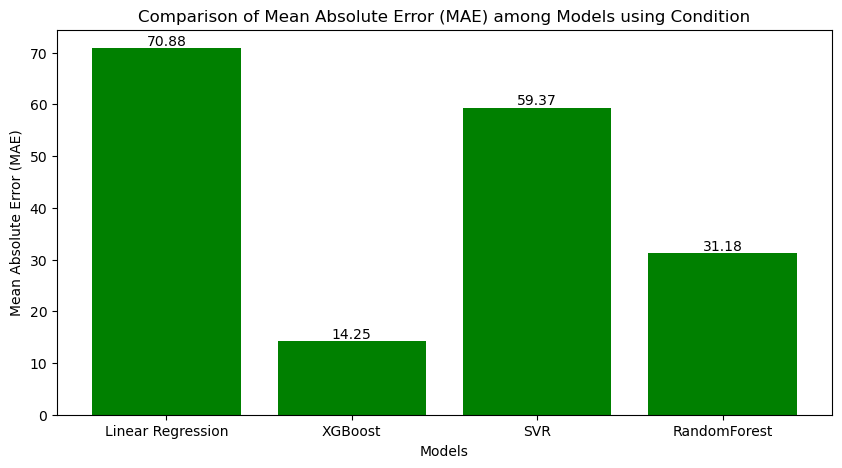

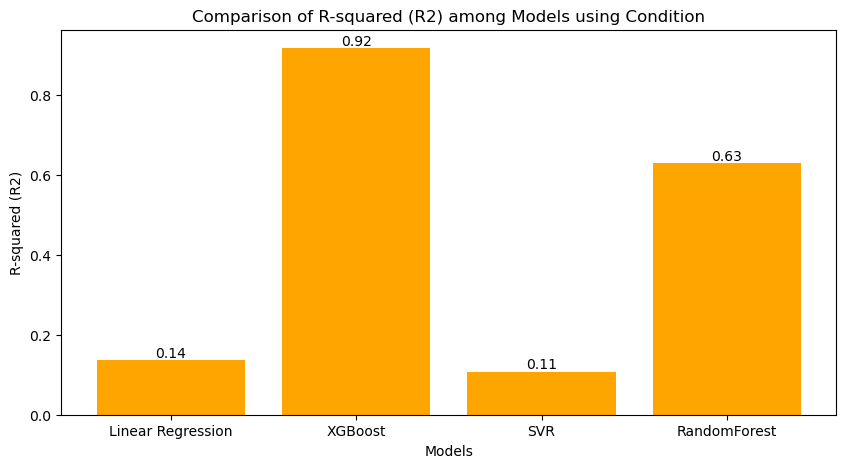

In [10]:
import matplotlib.pyplot as plt

# Create a list of model names and their respective metrics
models = ['Linear Regression', 'XGBoost', 'SVR', 'RandomForest']
mse_scores = [linear_mse, xgboost_mse, svr_mse, rf_mse]
mae_scores = [linear_mae, xgboost_mae, svr_mae,rf_mae]
r2_scores = [linear_r2, xgboost_r2, svr_r2,rf_r2]

# Plot Mean Squared Error (MSE)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, mse_scores, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) among Models using Condition')

# Add annotations to the bars
for bar, mse in zip(bars, mse_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mse:.2f}', ha='center', va='bottom')

plt.show()


# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, mae_scores, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error (MAE) among Models using Condition')
# Add annotations to the bars
for bar, mae in zip(bars, mae_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mae:.2f}', ha='center', va='bottom')

plt.show()

# Plot R-squared (R2)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, r2_scores, color='orange')
plt.xlabel('Models')
plt.ylabel('R-squared (R2)')
plt.title('Comparison of R-squared (R2) among Models using Condition')
# Add annotations to the bars
for bar, r2 in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{r2:.2f}', ha='center', va='bottom')

plt.show()

